In [1]:
# Network/data is small enough that running on GPU slows training down

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [29]:
import pandas as pd

df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [30]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [31]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563,-2.8185,54.9349,4.8878,77.8,2880.0,NaN,NaN,R,0.0,180330_000704,1.6456,3.4918,NaN,NaN,B,NaN,9.0882,-112.7488,2.2400,NaN,NaN,12.0


In [32]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 90)

# Load player IDs

In [33]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [34]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [35]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [36]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [37]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [38]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [39]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(572572, 96)

In [40]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
275104,66.0,1.0,ATL,-6.2967,30.3306,-13.6671,0.0,2.0,3.0,607257.0,fly_ball,NaN,NaN,Raffy Lopez flies out to left fielder Charlie ...,hit_into_play,92.313,NaN,0.005,0.008,field_out,452095.0,452095.0,518692.0,645277.0,622666.0,621020.0,518586.0,488721.0,455976.0,1.0,2018-06-06,530319.0,R,2018.0,52.91,107.92,276.0,7.0,3.0,SD,Standard,8.0,Bot,0.0,45.0,85.9,3.0,Standard,NaN,605486.0,NaN,2.0,R,-0.4055,1.4898,4-Seam Fastball,4.0,FF,595465.0,595465.0,0.1673,3.0569,Dan Winkler,1.0,3.0,1.0,3.0,5.947,-1.9372,54.5510,5.3602,93.1,2499.0,NaN,NaN,L,1.0,180606_222022,1.3352,2.9831,NaN,NaN,X,NaN,6.2287,-135.3081,-3.3090,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
150983,57.0,5.0,TB,-13.3576,32.6863,-13.8830,NaN,1.0,5.0,608654.0,NaN,NaN,NaN,NaN,ball,98.205,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,435079.0,446359.0,592743.0,457708.0,545361.0,594777.0,0.0,2018-05-19,530090.0,R,2018.0,NaN,NaN,NaN,NaN,0.0,LAA,Standard,8.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.7744,1.2833,2-Seam Fastball,4.0,FT,605121.0,605121.0,1.4179,3.6637,Justin Anderson,5.0,5.0,0.0,0.0,5.845,-2.4402,54.6543,6.1633,99.3,2329.0,NaN,NaN,R,2.0,180520_032621,1.3007,2.9210,NaN,NaN,B,NaN,12.1851,-143.9274,-4.2955,NaN,NaN,12.0,NaN,NaN,NaN,605121.0,Justin Anderson,anderju01
321032,70.0,7.0,TEX,4.1491,24.0123,-38.2105,NaN,0.0,7.0,624636.0,NaN,NaN,NaN,NaN,ball,80.518,NaN,NaN,NaN,NaN,571974.0,571974.0,502671.0,606466.0,500871.0,605113.0,445055.0,572041.0,519306.0,5.0,2018-07-30,531008.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,ARI,Standard,8.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,R,0.5110,-0.5834,Curveball,1.0,CU,542882.0,542882.0,-0.4774,3.1785,Matt Andriese,7.0,7.0,5.0,5.0,5.427,-2.1383,55.0752,5.6968,82.0,2727.0,NaN,NaN,R,0.0,180731_045911,1.4119,3.1909,NaN,NaN,B,NaN,2.7527,-119.2274,1.9446,NaN,NaN,1.0,NaN,NaN,NaN,542882.0,Matt Andriese,andrima01
418552,56.0,1.0,CHC,-4.7797,23.8865,-27.2422,NaN,1.0,7.0,602922.0,NaN,NaN,NaN,NaN,swinging_strike,86.791,NaN,NaN,NaN,NaN,605170.0,605170.0,519203.0,502517.0,623520.0,595879.0,450314.0,546991.0,592178.0,1.0,2018-09-21,531700.0,R,2018.0,NaN,NaN,NaN,NaN,7.0,CWS,Standard,7.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,L,-0.5781,0.3674,Cutter,3.0,FC,600968.0,600968.0,-1.1424,1.1568,Randy Rosario,1.0,7.0,1.0,7.0,5.751,2.4503,54.7483,6.1366,87.5,2366.0,NaN,NaN,R,1.0,180921_223434,1.5816,3.3594,NaN,NaN,S,NaN,-7.4127,-127.0999,-6.5653,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
235247,29.0,0.0,PIT,-17.6150,23.2096,-21.3739,NaN,1.0,4.0,506747.0,NaN,NaN,NaN,NaN,called_strike,90.419,NaN,NaN,NaN,NaN,465041.0,465041.0,605137.0,624428.0,501896.0,446481.0,640457.0,516782.0,570256.0,0.0,2018-06-03,530295.0,R,2018.0,NaN,NaN,NaN,NaN,4.0,STL,Standard,4.0,Bot,NaN,NaN,NaN,NaN,Standard,543939.0,NaN,NaN,2.0,R,-1.3666,0.8504,2-Seam Fastball,2.0,FT,592468.0,592468.0,0.8158,2.1639,Nick Kingham,0.0,4.0,0.0,4.0,5.575,-2.1662,54.9236,6.4438,91.2,2112.0,NaN,NaN,R,0.0,180603_191023,1.6128,3.4188,NaN,NaN,S,NaN,1

# Load statistics

## Batting

In [41]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [44]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [46]:
stats = batting_stats  # alias
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [72]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [71]:
# pitching_stats.

In [73]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False).IPouts.sum()
pitching_stats.shape

(581, 2)

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [49]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'field_error', 'catcher_interf', 'force_out', 'double_play',
       'sac_fly', 'other_out', 'fielders_choice_out', 'pickoff_1b',
       'strikeout_double_play', 'fielders_choice', 'caught_stealing_3b',
       'pickoff_2b', 'triple_play', 'sac_bunt_double_play',
       'caught_stealing_home', 'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run', 'batter_interference'], dtype=object)

In [50]:
target_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]
target_events = {event: i for i, event in enumerate(target_events, start=1)}
on_base_event_map = {event: target_events.get(event, 0) for event in df.events.unique()}
df['target'] = df.events.map(on_base_event_map)

In [51]:
on_base_event_map

{'single': 1,
 nan: 0,
 'triple': 3,
 'strikeout': 0,
 'field_out': 0,
 'double': 2,
 'walk': 5,
 'grounded_into_double_play': 0,
 'home_run': 4,
 'hit_by_pitch': 0,
 'sac_bunt': 0,
 'pickoff_caught_stealing_2b': 0,
 'caught_stealing_2b': 0,
 'field_error': 0,
 'catcher_interf': 0,
 'force_out': 0,
 'double_play': 0,
 'sac_fly': 0,
 'other_out': 0,
 'fielders_choice_out': 0,
 'pickoff_1b': 0,
 'strikeout_double_play': 0,
 'fielders_choice': 0,
 'caught_stealing_3b': 0,
 'pickoff_2b': 0,
 'triple_play': 0,
 'sac_bunt_double_play': 0,
 'caught_stealing_home': 0,
 'sac_fly_double_play': 0,
 'pickoff_3b': 0,
 'pickoff_caught_stealing_home': 0,
 'pickoff_caught_stealing_3b': 0,
 'run': 0,
 'batter_interference': 0}

# Who's on first

Or rather, is anyone on first.

In [52]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [53]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitchers has the pitcher thrown

In [54]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3983,529406.0,1.0,1.0,502042.0,1,1
3970,529406.0,2.0,1.0,502042.0,1,2
3957,529406.0,2.0,2.0,502042.0,1,3
3947,529406.0,2.0,3.0,502042.0,1,4
3938,529406.0,3.0,1.0,502042.0,1,5
3919,529406.0,3.0,2.0,502042.0,1,6
3909,529406.0,3.0,3.0,502042.0,1,7
3901,529406.0,3.0,4.0,502042.0,1,8
3886,529406.0,3.0,5.0,502042.0,1,9
3872,529406.0,3.0,6.0,502042.0,1,10


In [55]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [57]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [59]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(820, 2)

## Create pitcher IDs to be embedded

In [76]:
eligible_pitchers = pitching_stats[pitching_stats.IPouts > (20*3)].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [79]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number'
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team'
]

target = 'target'

# Define an encoder

To map IDs to valid range for `keras` embedding layers

In [80]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

# Recurrent model

## Build batches for training

In [82]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [83]:
if False:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [84]:
df_sample.shape

(572572, 104)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [88]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    y = np.zeros((len(target_events) + 1,))
    assert len(group_df.target.unique()) <= 2
    y[group_df.target.max()] = 1
    return x, y, len(x['numeric_inputs'])

In [89]:
import multiprocessing as mp
import numpy as np

# this takes so long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, batch_lens = zip(*res)

Process ForkPoolWorker-73:
Process ForkPoolWorker-70:
Process ForkPoolWorker-72:
Process ForkPoolWorker-75:
Process ForkPoolWorker-71:
Process ForkPoolWorker-74:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multipro

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiproc

In [90]:
len(X_train), len(y_train)

(146622, 146622)

## Create a list of the batches

In [91]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(146622, 4474)

In [94]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [95]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))

In [99]:
def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        yield X_batch, np.array(ys)
        

In [100]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [101]:
len(batches)

4474

In [102]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape

((127, 1, 9), (127, 6))

In [103]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape

((2, 21, 9), (2, 6))

## build model

In [104]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 2,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
batter_embedding = Avg(embeddings.pop('batter_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='final_transformation')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

In [105]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [106]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [107]:
def g():
    while True:
        np.random.shuffle(batches)
        for X, y in batches:
            yield X, y
model.fit_generator(g(), steps_per_epoch=len(batches), epochs=30)

Epoch 1/30
4474/4474 [==============================] - 41s 9ms/step - loss: 0.8224
Epoch 2/30
4474/4474 [==============================] - 38s 8ms/step - loss: 0.7582
Epoch 3/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7468
Epoch 4/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7401
Epoch 5/30
4474/4474 [==============================] - 38s 8ms/step - loss: 0.7364
Epoch 6/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7348
Epoch 7/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7326
Epoch 8/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7319
Epoch 9/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7308
Epoch 10/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7299
Epoch 11/30
4474/4474 [==============================] - 38s 9ms/step - loss: 0.7291
Epoch 12/30
4474/4474 [==============================] - 39s 9ms/step - lo

KeyboardInterrupt: 

## P/R curves

In [108]:
preds = np.concatenate([model.predict(x) for x, _ in batches])
y_all = np.concatenate([y for _, y in batches])

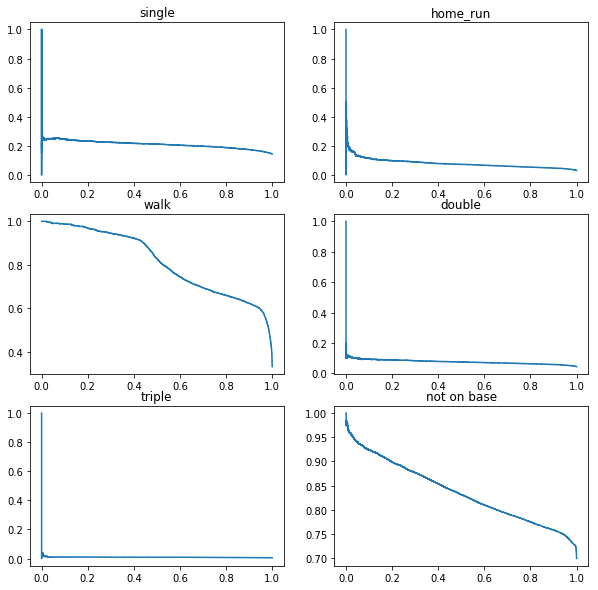

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].plot(r, p)
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

# Inspect model

## Defining utility functions

In [110]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at batter embeddings

In [112]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', model)
batters['x'], batters['y'] = zip(*batter_embeddings.reshape((-1, 2)))

In [113]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

batters['sort_key'] = batters.batter_mlbname.isin(lookat)
batters.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [114]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [115]:
pitcher_weights = model.get_layer('final_transformation').get_weights()[0][-4:-2, :]
batter_weights = model.get_layer('final_transformation').get_weights()[0][-2:, :]

In [116]:
target_events

{'single': 1, 'double': 2, 'triple': 3, 'home_run': 4, 'walk': 5}

In [117]:
batters['prob_on_base'] = np.dot(batters[['x', 'y']].values, batter_weights)[:, 1:].sum(axis=1)  # this is contribution of prob of on-base

In [118]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'prob_on_base'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            prob_on_base=batters.prob_on_base
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [120]:
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,x,y,sort_key,prob_on_base
0,605141.0,Mookie Betts,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.438111,0.782692,1.220803,-0.015107,0.453525,True,0.293997
92,514888.0,Jose Altuve,514888.0,169,55,6.0,29,2,13,1.0,534,155,0.385906,0.507491,0.893397,0.301567,0.225139,False,0.264947
232,461314.0,Matt Kemp,461314.0,134,36,1.0,25,0,21,7.0,462,130,0.337945,0.571429,0.909373,0.084497,0.285815,False,0.221479
190,518692.0,Freddie Freeman,518692.0,191,76,7.0,44,4,23,6.0,618,174,0.387553,0.592233,0.979786,0.081360,0.272512,False,0.211477
320,576397.0,Jedd Gyorko,576397.0,92,44,3.0,19,1,11,4.0,351,85,0.345771,0.484330,0.830102,0.033665,0.205938,False,0.149103
73,571448.0,Nolan Arenado,571448.0,175,73,3.0,38,2,38,6.0,590,177,0.373512,0.696610,1.070122,-0.107005,0.287020,False,0.148541
258,543685.0,Anthony Rendon,543685.0,163,55,5.0,44,2,24,8.0,529,145,0.373534,0.633270,1.006805,0.011506,0.217261,False,0.148056
268,571697.0,Scooter Gennett,571697.0,181,42,4.0,30,3,23,5.0,584,177,0.357480,0.578767,0.936247,0.236297,0.082469,False,0.145500
261,435062.0,Howard Kendrick,435062.0,46,5,2.0,14,0,4,1.0,152,36,0.331250,0.526316,0.857566,0.038498,0.180652,False,0.134247
260,475582.0,Ryan Zimmerman,475582.0,76,30,3.0,21,2,13,2.0,288,70,0.337461,0.590278,0.927739,-0.232665,0.335885,False,0.132461


## look at pitchers

In [121]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [122]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = {
    'Noah Syndergaard': 'red',
    'Clayton Kershaw': 'green',
    'Aaron Nola': 'orange',
    'Craig Kimbrel': 'pink'
}

pitchers['sort_key'] = pitchers.player_name.isin(lookat)
pitchers.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)

Loading BokehJS ...

In [123]:
pitchers['prob_not_on_base'] = np.dot(pitchers[['x', 'y']].values, pitcher_weights)[:, 0]

In [124]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = 'prob_not_on_base'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            prob_not_on_base=pitchers.prob_not_on_base
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

In [126]:
pitchers.sort_values('prob_not_on_base', ascending=False).head(10)

,pitcher_id,player_name,x,y,sort_key,prob_not_on_base
368951,543507.0,Trevor May,-1.028998,0.973466,False,0.925012
336198,606167.0,Adalberto Mejia,-1.433551,0.561134,False,0.840030
386,493603.0,Adam Ottavino,-1.439427,0.522362,False,0.820296
600,476454.0,Dellin Betances,-1.614855,0.408295,False,0.819974
1382,489446.0,Kirby Yates,-0.971563,0.799544,False,0.805897
574,467008.0,Pedro Strop,-1.165552,0.658150,False,0.796932
289632,424144.0,Oliver Perez,-1.638031,0.347506,False,0.794132
275663,650895.0,Diego Castillo,-0.966451,0.711743,False,0.754484
33662,453172.0,Jared Hughes,-1.476221,0.378075,False,0.752307
1932,600917.0,Jose Leclerc,-1.377557,0.396036,False,0.726421


## Look at attention

In [127]:
A = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [135]:
batch_idx = 1
bx, by = batches[batch_idx]
aa = np.squeeze(A.predict(bx))
bx['numeric_inputs'].shape, aa.shape

((32, 4, 9), (32, 4))

In [136]:
aa

array([[3.16199273e-01, 1.21175326e-01, 1.65545076e-01, 3.97080332e-01],
       [2.47497410e-01, 1.01525381e-01, 1.69546813e-01, 4.81430352e-01],
       [2.00271323e-01, 8.64495859e-02, 1.68075711e-01, 5.45203388e-01],
       [1.90687940e-01, 8.44387040e-02, 1.82020098e-01, 5.42853236e-01],
       [3.21327039e-04, 1.44017366e-04, 3.61472426e-04, 9.99173105e-01],
       [2.79543340e-01, 1.27051637e-01, 1.92972377e-01, 4.00432676e-01],
       [7.25149829e-03, 2.97211180e-03, 6.07503066e-03, 9.83701408e-01],
       [2.67427802e-01, 1.24623947e-01, 2.08001420e-01, 3.99946839e-01],
       [9.70451874e-05, 4.39210999e-05, 9.58094388e-05, 9.99763191e-01],
       [1.79528579e-01, 7.62375966e-02, 8.48218948e-02, 6.59411907e-01],
       [2.94395328e-01, 1.39844909e-01, 1.53637633e-01, 4.12122160e-01],
       [3.11417341e-01, 1.11774497e-01, 1.95041209e-01, 3.81766886e-01],
       [2.27249712e-01, 1.01686649e-01, 1.91512421e-01, 4.79551256e-01],
       [2.94871867e-01, 1.15134686e-01, 1.40812874e

In [137]:
np.argmax(aa, axis=1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3])

In [138]:
p = model.predict(bx)

In [139]:
inverse_target_map = {v: k for k, v in target_events.items()}
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [140]:
bx

{'if_fielding_alignment_input': array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 1],
        [2, 2, 2, 2],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [1, 1, 1, 1]], dtype=int32),
 'of_fielding_alignment_input': array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],

In [143]:
idx = 0
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher_id', 'player_name']])

print('was', inverse_target_map.get(np.argmax(by[idx]), 'not on base event'))
print('predicted', inverse_target_map.get(np.argmax(p[idx]), 'not on base event'))

with pd.option_context('display.max_columns', None):
    display(d)

was not on base event
predicted not on base event


,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher_id,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,attention,batter_mlbname,player_name
0,2,0,0,0,0,1,6,78,39,Standard,Standard,Top,Slider,14.0,570632.0,571437.0,R,R,0,0,0,PHI,MIA,0.316199,Aaron Altherr,Jose Urena
1,2,0,1,0,0,2,6,79,39,Standard,Standard,Top,2-Seam Fastball,9.0,570632.0,571437.0,R,R,0,0,0,PHI,MIA,0.121175,Aaron Altherr,Jose Urena
2,2,0,1,1,0,3,6,80,39,Standard,Standard,Top,Changeup,7.0,570632.0,571437.0,R,R,0,0,0,PHI,MIA,0.165545,Aaron Altherr,Jose Urena
3,2,0,1,2,0,4,6,81,39,Standard,Standard,Top,Slider,9.0,570632.0,571437.0,R,R,0,0,0,PHI,MIA,0.397080,Aaron Altherr,Jose Urena


# counterfactuals

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [ ]:
batch_idx = 0
idx = 0
bx, by = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')

In [ ]:
bx